In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("AmesHousing.csv", sep="\t")
pd.options.future.infer_string = True

print("shape:", df.shape)
print(df.head(10))
print(df.dtypes.value_counts())



shape: (2930, 82)
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   
5      6  527105030           60        RL          78.0      9978   Pave   
6      7  527127150          120        RL          41.0      4920   Pave   
7      8  527145080          120        RL          43.0      5005   Pave   
8      9  527146030          120        RL          39.0      5389   Pave   
9     10  527162130           60        RL          60.0      7500   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [3]:
df.dtypes.value_counts()

object     43
int64      28
float64    11
Name: count, dtype: int64

In [4]:
df.duplicated().any()

np.False_

In [5]:
missing = df.isnull().sum().sort_values(ascending=False).head(30)
print(missing)

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Qual        159
Garage Yr Blt      159
Garage Cond        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Total Bsmt SF        1
BsmtFin SF 1         1
BsmtFin SF 2         1
Garage Area          1
Garage Cars          1
Bsmt Unf SF          1
Electrical           1
Lot Shape            0
Street               0
Lot Area             0
dtype: int64


In [6]:
print(df.columns)

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [7]:
df.dtypes

Order               int64
PID                 int64
MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
                   ...   
Mo Sold             int64
Yr Sold             int64
Sale Type          object
Sale Condition     object
SalePrice           int64
Length: 82, dtype: object

In [8]:
# 2.1) dicționar valori "nu există"
na_none_map = {
    'Alley': 'NoAlley',
    'Bsmt Qual': 'NoBasement',
    'Bsmt Cond': 'NoBasement',
    'Bsmt Exposure': 'NoBasement',
    'BsmtFin Type 1': 'NoBasement',
    'BsmtFin Type 2': 'NoBasement',
    'Fireplace Qu': 'NoFireplace',
    'Garage Type': 'NoGarage',
    'Garage Finish': 'NoGarage',
    'Garage Qual': 'NoGarage',
    'Garage Cond': 'NoGarage',
    'Pool QC': 'NoPool',
    'Fence': 'NoFence',
    'Misc Feature': 'NoFeature'
}

# 2.2) aplicare simplă
for col, val in na_none_map.items():
    if col in df.columns:
        df[col] = df[col].replace('NA', val).fillna(val)

print("după NA semantice ok")


după NA semantice ok


In [9]:
# 3.1) detectez dacă există subsol din arii
has_bsmt_area = (df[['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF']].fillna(0).sum(axis=1) > 0)

# 3.2) dacă are arie, dar 'Bsmt Exposure' este 'NoBasement' => pun 'No'
bad_expo = has_bsmt_area & (df['Bsmt Exposure'] == 'NoBasement')
df['Fix_BsmtExposure'] = 0
df.loc[bad_expo, 'Bsmt Exposure'] = 'No'
df.loc[bad_expo, 'Fix_BsmtExposure'] = 1

print("fix basement exposure:", df['Fix_BsmtExposure'].sum(), "rânduri")


fix basement exposure: 3 rânduri


In [10]:
# 4.1) rândurile care par să aibă garaj
g_has = (df['Garage Type'] != 'NoGarage') | (df['Garage Area'].fillna(0) > 0) | (df['Garage Cars'].fillna(0) > 0)

# 4.2) modă per tip (pe fiecare col etichetă)
def simple_mode(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

label_cols = ['Garage Finish','Garage Qual','Garage Cond']
modes_by_type = df[g_has].groupby('Garage Type')[label_cols].agg(simple_mode)

# 4.3) mediane per tip pentru numerice
med_area_by_type = df[g_has].groupby('Garage Type')['Garage Area'].median()
med_cars_by_type = df[g_has].groupby('Garage Type')['Garage Cars'].median()

# 4.4) repar etichetele "NoGarage" la casele care au garaj
df['Fix_Garage'] = 0
need_fix = g_has & (
    (df['Garage Finish'] == 'NoGarage') |
    (df['Garage Qual']   == 'NoGarage') |
    (df['Garage Cond']   == 'NoGarage')
)

for c in label_cols:
    mask = need_fix & ((df[c] == 'NoGarage') | df[c].isna())
    fill_vals = df.loc[mask, 'Garage Type'].map(modes_by_type[c])
    df.loc[mask, c] = fill_vals
    df.loc[mask, 'Fix_Garage'] = 1

# 4.5) completez lipsuri numerice (area, cars) cu mediană pe tip
mask_area_na = g_has & df['Garage Area'].isna()
mask_cars_na = g_has & df['Garage Cars'].isna()
df.loc[mask_area_na, 'Garage Area'] = df.loc[mask_area_na, 'Garage Type'].map(med_area_by_type)
df.loc[mask_cars_na, 'Garage Cars'] = df.loc[mask_cars_na, 'Garage Type'].map(med_cars_by_type)
df.loc[mask_area_na | mask_cars_na, 'Fix_Garage'] = 1

print("fix garage:", df['Fix_Garage'].sum(), "rânduri")


fix garage: 2 rânduri


In [11]:
# 5.1) patru cazuri simple
area = df['Mas Vnr Area']
typ  = df['Mas Vnr Type']

m_area0 = area.fillna(0) == 0
m_area_pos = area.fillna(0) > 0
m_type_none = typ == 'None'
m_type_na = typ.isna()
m_type_notnone = ~(m_type_none | m_type_na)

# 5.2) cazuri ușoare
df.loc[m_type_na & m_area0, 'Mas Vnr Type'] = 'None'
df.loc[m_type_notnone & m_area0, 'Mas Vnr Type'] = 'None'

# 5.3) trebuie tip când aria > 0 -> modă pe Neighborhood, fallback global
global_mode = df['Mas Vnr Type'].dropna().mode()
global_mode = global_mode.iloc[0] if len(global_mode) else 'BrkFace'

if 'Neighborhood' in df.columns:
    ref = df[m_area_pos & ~m_type_none & ~m_type_na]
    nb_mode = ref.groupby('Neighborhood')['Mas Vnr Type'].agg(simple_mode)
    mask_A = m_type_none & m_area_pos
    mask_D = m_type_na   & m_area_pos
    df.loc[mask_A, 'Mas Vnr Type'] = df.loc[mask_A, 'Neighborhood'].map(nb_mode).fillna(global_mode)
    df.loc[mask_D, 'Mas Vnr Type'] = df.loc[mask_D, 'Neighborhood'].map(nb_mode).fillna(global_mode)
else:
    df.loc[m_area_pos & (m_type_none | m_type_na), 'Mas Vnr Type'] = global_mode

print("masonry veneer ok")


masonry veneer ok


In [12]:
parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']
total = 'Total Bsmt SF'

sum_parts = df[parts].fillna(0).sum(axis=1)
all_parts_na = df[parts].isna().all(axis=1)
total_na = df[total].isna()

# 6.1) setez total = suma părților când lipsă / diferit
mask_true_mismatch = (~all_parts_na) & (~total_na) & (df[total] != sum_parts)
mask_total_missing = (~all_parts_na) & total_na
df.loc[mask_true_mismatch, total] = sum_parts[mask_true_mismatch]
df.loc[mask_total_missing, total] = sum_parts[mask_total_missing]

# 6.2) dacă doar părțile lipsesc, dar total există -> pun 0 la părți
mask_parts_missing = all_parts_na & (~total_na)
for c in parts:
    df.loc[mask_parts_missing, c] = df.loc[mask_parts_missing, c].fillna(0)

# 6.3) dacă toate lipsesc și eticheta e NoBasement -> pun 0 peste tot
mask_all_missing = all_parts_na & total_na & (df['Bsmt Qual'] == 'NoBasement')
for c in parts + [total]:
    df.loc[mask_all_missing, c] = 0

print("basement identities ok")


basement identities ok


In [13]:
# 7.1) vânzarea trebuie să fie după construit și după remodel
mask_time_ok = (df['Yr Sold'] >= df['Year Built']) & (df['Yr Sold'] >= df['Year Remod/Add'])
df = df[mask_time_ok].copy()

# 7.2) remodel nu poate fi înainte de construit
df = df[df['Year Remod/Add'] >= df['Year Built']].copy()

# 7.3) anul garajului plauzibil (>=1880 și <= YearSold + 1)
mask_gyear_ok = (~df['Garage Yr Blt'].notna()) | (
    (df['Garage Yr Blt'] >= 1880) & (df['Garage Yr Blt'] <= (df['Yr Sold'] + 1))
)
df = df[mask_gyear_ok].copy()

print("time checks ok; shape:", df.shape)


time checks ok; shape: (2925, 84)


In [14]:
# 8.1) flags
df['HasPool']   = (df['Pool Area'] > 0).astype(int)
df['HasFire']   = (df['Fireplaces'] > 0).astype(int)
df['HasAC']     = (df['Central Air'] == 'Y').astype(int)
df['HasFence']  = (df['Fence'] != 'NoFence').astype(int)
df['HasGarage'] = (df['Garage Cars'].fillna(0) > 0).astype(int)
df['AmenitiesCount'] = df[['HasPool','HasFire','HasAC','HasFence','HasGarage']].sum(axis=1)

# 8.2) log-uri utile
for c in ['Lot Area','Gr Liv Area','Total Bsmt SF','1st Flr SF','Garage Area','SalePrice']:
    if c in df.columns:
        safe = df[c].clip(lower=0)
        df[f'log_{c.replace(" ","").replace("/","_")}'] = np.log1p(safe)

print("flags + logs ok")


flags + logs ok


In [15]:
# 9.1) Lot Frontage: mediană pe cartier (fallback mediană globală)
if 'Lot Frontage' in df.columns and 'Neighborhood' in df.columns:
    med_glob = df['Lot Frontage'].median()
    med_nb = df.groupby('Neighborhood')['Lot Frontage'].transform('median')
    df['Lot Frontage'] = df['Lot Frontage'].fillna(med_nb).fillna(med_glob)

# 9.2) numeric unde NaN = "nu există" -> 0 + indicator
exist_num = [
    'Garage Yr Blt','Garage Area','Garage Cars',
    'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
    'Bsmt Full Bath','Bsmt Half Bath','Pool Area','Mas Vnr Area'
]
for c in exist_num:
    if c in df.columns:
        df[f'{c}_was_missing'] = df[c].isna().astype(int)
        df[c] = df[c].fillna(0)

# 9.3) restul numericelor -> mediană globală
num_cols_all = df.select_dtypes(include=[np.number]).columns
for c in num_cols_all:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

print("imputări ok")


imputări ok


In [16]:
# todo drop PID','Order' after plot

to_drop = [
    'Utilities','Street','Condition 2','Roof Matl','Heating',  # aproape-constante
    'Pool QC','Misc Feature',         # super lipsă (păstrăm HasPool)
    'Garage Cond',                    # redundantă cu Garage Qual
    'Fix_Garage','Fix_BsmtExposure'   # flaguri de audit
]
keep = [c for c in to_drop if c in df.columns]
df = df.drop(columns=keep).copy()

print("drop ok. shape:", df.shape)


drop ok. shape: (2925, 97)


In [17]:
# === 11) Ordinale -> cod numeric + OHE pe nominale + X/y ===

# 11.1) definire ordine pentru variabilele ordinale (cu denumirile exacte din dataframe)
ord_orders = {
    'Exter Qual':    ['Po','Fa','TA','Gd','Ex'],
    'Exter Cond':    ['Po','Fa','TA','Gd','Ex'],
    'Bsmt Qual':     ['NoBasement','Po','Fa','TA','Gd','Ex'],
    'Bsmt Cond':     ['NoBasement','Po','Fa','TA','Gd','Ex'],
    'Bsmt Exposure': ['NoBasement','No','Mn','Av','Gd'],
    'BsmtFin Type 1':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'BsmtFin Type 2':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'Heating QC':    ['Po','Fa','TA','Gd','Ex'],
    'Electrical':    ['FuseP','FuseF','Mix','FuseA','SBrkr'],
    'Kitchen Qual':  ['Po','Fa','TA','Gd','Ex'],
    'Fireplace Qu':  ['NoFireplace','Po','Fa','TA','Gd','Ex'],
    'Garage Finish': ['NoGarage','Unf','RFn','Fin'],
    'Garage Qual':   ['NoGarage','Po','Fa','TA','Gd','Ex'],
    'Paved Drive':   ['N','P','Y'],
    'Lot Shape':     ['IR3','IR2','IR1','Reg'],
    'Land Slope':    ['Sev','Mod','Gtl'],
    # Dacă vrei și 'Functional', decomentează linia de mai jos și asigură-te că ai coloana:
    # 'Functional':    ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
}

# 11.1-bis) mapare efectivă la coduri (−1 -> NaN)
for col, order in ord_orders.items():
    if col in df.columns:
        cat = pd.Categorical(df[col], categories=order, ordered=True)
        s = pd.Series(cat.codes, index=df.index).astype('float64')  # array -> Series
        s[s == -1] = np.nan                                        # valori în afara listelor -> NaN
        df[col] = s

# 11.2) One-Hot Encoding pe nominale “pure”
ohe_cols = [
    'MS SubClass','MS Zoning','Neighborhood','Condition 1','Bldg Type',
    'House Style','Roof Style','Exterior 1st','Exterior 2nd','Mas Vnr Type',
    'Foundation','Lot Config','Land Contour','Garage Type','Sale Type','Sale Condition'
]
ohe_cols = [c for c in ohe_cols if c in df.columns]  # păstrează doar ce există

# 11.3) construiesc X și y
y = df['SalePrice'].astype(float)
X = pd.get_dummies(
    df.drop(columns=['SalePrice']),
    columns=ohe_cols,
    drop_first=False,
    dtype=int
)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2925, 235)
y shape: (2925,)


C:\Users\scoti\PycharmProjects\ML_Projects\Lab1_ML\.venv\Lib\site-packages\pandas\core\indexes\base.py:7697: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)
C:\Users\scoti\PycharmProjects\ML_Projects\Lab1_ML\.venv\Lib\site-packages\pandas\core\indexes\base.py:7697: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)
C:\Users\scoti\PycharmProjects\ML_Projects\Lab1_ML\.venv\Lib\site-packages\pandas\core\indexes\base.py:7697: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep 

P99 area: 2872.0 | P99 price: 456784.0 | nr out. price: 30


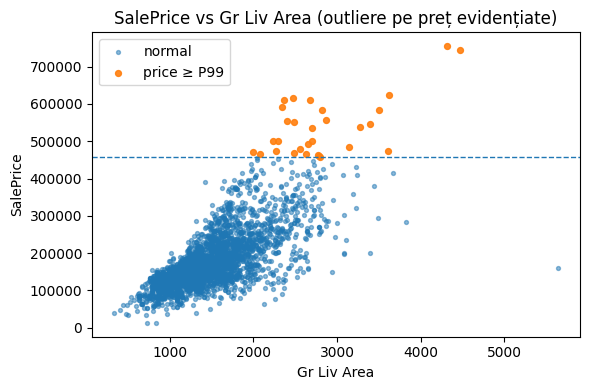

In [18]:
# 12.1) prag P99 pentru Gr Liv Area și SalePrice
p99_area = df['Gr Liv Area'].quantile(0.99)
p99_price = df['SalePrice'].quantile(0.99)

mask_hp = df['SalePrice'] > p99_price  # outliere de preț (sus)
print("P99 area:", round(p99_area,1), "| P99 price:", round(p99_price,0), "| nr out. price:", int(mask_hp.sum()))

# 12.2) scatter cu outlierele colorate diferit
plt.figure(figsize=(6,4))
plt.scatter(df.loc[~mask_hp,'Gr Liv Area'], df.loc[~mask_hp,'SalePrice'], s=8, alpha=0.5, label='normal')
plt.scatter(df.loc[mask_hp,'Gr Liv Area'], df.loc[mask_hp,'SalePrice'], s=18, alpha=0.9, label='price ≥ P99')
plt.axhline(p99_price, linestyle='--', linewidth=1)
plt.title("SalePrice vs Gr Liv Area (outliere pe preț evidențiate)")
plt.xlabel("Gr Liv Area")
plt.ylabel("SalePrice")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
#todo  in progress - outlier handling
df['HasPool']   = (df['Pool Area'].fillna(0) > 0).astype(int)
df['HasFire']   = (df['Fireplaces'].fillna(0) > 0).astype(int)
df['HasAC']     = (df['Central Air'].replace({'Y':1,'N':0}).fillna(0) == 1).astype(int)
df['HasFence']  = (df['Fence'].fillna('NoFence') != 'NoFence').astype(int)
df['HasGarage'] = (df['Garage Cars'].fillna(0) > 0).astype(int)

df['AmenitiesCount'] = df[['HasPool','HasFire','HasAC','HasFence','HasGarage']].sum(axis=1)


C:\Users\scoti\AppData\Local\Temp\ipykernel_19380\1084699936.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HasAC']     = (df['Central Air'].replace({'Y':1,'N':0}).fillna(0) == 1).astype(int)
